# Network size scaling

In [1]:
import numpy as np

arr = np.zeros((10, 10))
arr.nbytes

800

In [2]:
arr = np.zeros((1, 1))
arr.nbytes

8

In [3]:
n_nodes_range = np.unique(np.geomspace(1, 100_000, 25, dtype=int))
n_nodes_range

array([     1,      2,      4,      6,     11,     17,     28,     46,
           74,    121,    195,    316,    510,    825,   1333,   2154,
         3480,   5623,   9085,  14677,  23713,  38311,  61896, 100000])

In [4]:
n_edges_range = np.unique(np.geomspace(1, 10_000_000, 25, dtype=int))
n_edges_range

array([       1,        3,        7,       14,       28,       56,
            110,      215,      421,      825,     1615,     3162,
           6189,    12115,    23713,    46415,    90851,   177827,
         348070,   681292,  1333521,  2610157,  5108969, 10000000])

In [5]:
import pandas as pd
from graspologic.utils import cartesian_product


def numpy_n_bytes(n_nodes, n_edges):
    return n_nodes * n_nodes * 8


pairs = cartesian_product(n_nodes_range, n_edges_range)

rows = []
for n, m in pairs:
    n_bytes = numpy_n_bytes(n, m)
    rows.append({"n_nodes": n, "n_edges": m, "n_bytes": n_bytes})

size_df = pd.DataFrame(rows)

<AxesSubplot:xlabel='n_nodes', ylabel='n_edges'>

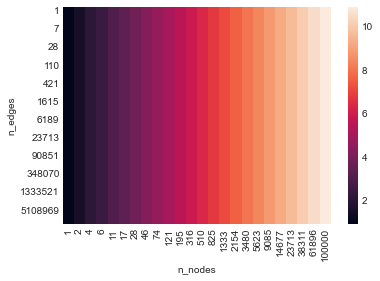

In [6]:
import seaborn as sns

square_size_df = size_df.pivot(index="n_edges", columns="n_nodes", values="n_bytes")
square_size_df = np.log10(square_size_df)

sns.heatmap(square_size_df)

In [7]:
my_mem = 16 * 1e9

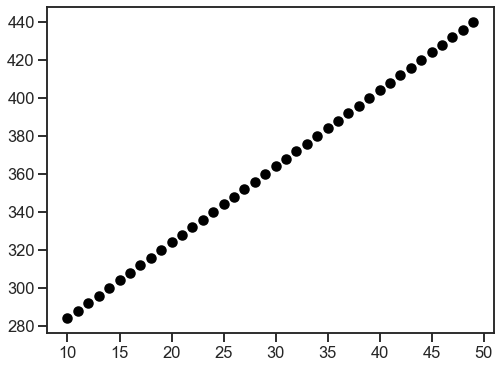

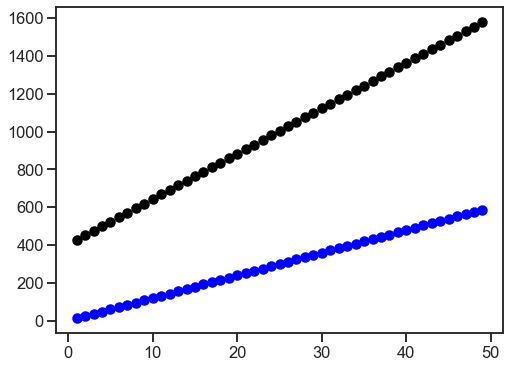

In [8]:
from scipy.sparse import csr_matrix
from graspologic.simulations import er_nm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

m = 10
for n in range(10, 50):
    A = er_nm(n, m)
    csr_mat = csr_matrix(A)
    n_bytes = csr_mat.data.nbytes + csr_mat.indptr.nbytes + csr_mat.indices.nbytes
    ax.scatter(n, n_bytes, color="black")


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
n = 100
for m in range(1, 50):
    A = er_nm(n, m)
    csr_mat = csr_matrix(A)
    n_bytes = csr_mat.data.nbytes + csr_mat.indptr.nbytes + csr_mat.indices.nbytes
    n_pred = 8 * m + 4 * m
    ax.scatter(m, n_bytes, color="black")
    ax.scatter(m, n_pred, color="blue")

In [10]:
ns = np.linspace(100, 1000, 10, dtype=int)
ms = np.linspace(1, 1000, 10, dtype=int)

In [11]:
Xs = cartesian_product(ns, ms)
Xs = np.repeat(Xs, 10, axis=0)


def calc_n_bytes(n, m, trials=10):
    A = er_nm(int(n), int(m), directed=True)
    csr_mat = csr_matrix(A)
    return csr_mat.data.nbytes + csr_mat.indptr.nbytes + csr_mat.indices.nbytes


ys = []
for x in Xs:
    ys.append(calc_n_bytes(*x))

In [12]:
Xs_coeffs = np.stack(
    (
        np.ones(len(Xs)),
        Xs[:, 0],
        Xs[:, 0] ** 2,
        Xs[:, 1],
        Xs[:, 1] ** 2,
        Xs[:, 0] * Xs[:, 1],
    )
).T
Xs_coeffs.shape

(1000, 6)

In [13]:
soln, resid, rank, s = np.linalg.lstsq(Xs_coeffs, ys, rcond=None)
print(np.array(soln))

[ 4.00000000e+00  4.00000000e+00  3.10862447e-15  1.20000000e+01
  1.33226763e-15 -4.44089210e-16]


In [14]:
n = 100
m = 500
A = er_nm(n, m, directed=True)
csr_mat = csr_matrix(A)
n_bytes_observed = csr_mat.data.nbytes + csr_mat.indptr.nbytes + csr_mat.indices.nbytes
n_bytes_pred = 4 * n + 12 * m + 4
print(n_bytes_observed)
print(n_bytes_pred)

6404
6404


In [15]:
ns = np.linspace(10, 100_000, 100)
ms = np.linspace(10, 10_000_000, 100)
xs = cartesian_product(ns, ms)
ys = 4 * xs[:, 0] + 12 * xs[:, 1] + 4

In [16]:
# 4 * x + 12 * y + 4 = b
# 4*x + 12*y = b - 4
# 12 y = b - 4 - 4x

SyntaxError: cannot assign to operator (2468000393.py, line 1)

[Text(0.5, 0, '# of nodes'), Text(0, 0.5, '# of edges')]

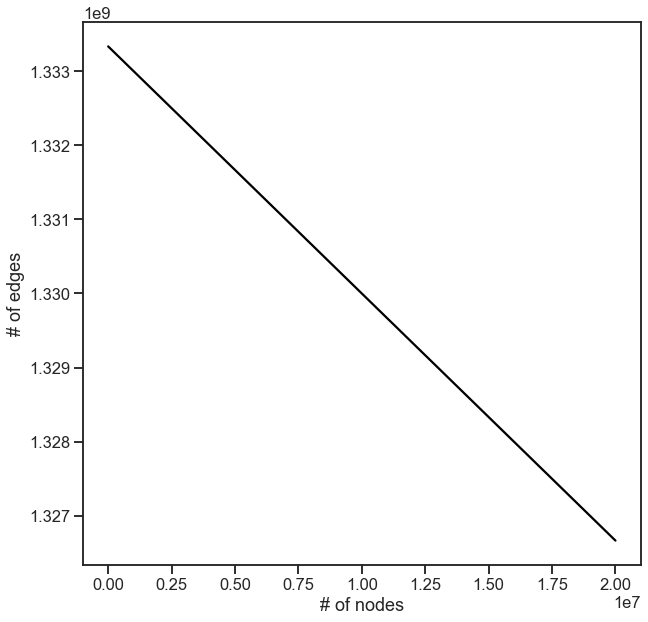

In [21]:
xs = np.linspace(10, 200000, 100)
b = 16 * 1e9
ys = (b - 4 - 4 * xs) / 12
# for i in range(len(ys)):
#     if ys[i] > xs[i]**2:
#         ys[i] = xs[i]**2

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(xs, ys, color="black")
# ax.plot(xs, xs**2, color='blue')
# ax.set(xlim=(0, 10_000), ylim=(0, 100_000))
# ax.set(xlim=(0, 200_000))
ax.set(xlabel="# of nodes", ylabel="# of edges")

In [ ]:
# const = soln
# n_linear = soln[0]
# m_linear = soln[1] # 0
# n_squared =

array([ 2.47636362e+02,  1.32000000e+00, -1.37861917e-12,  3.63636364e+01,
       -2.04208004e-11,  2.51430821e-14,  1.01152560e-10, -1.99554349e-13,
        0.00000000e+00])